In [1]:
import gc
import torch 
torch.cuda.empty_cache()

In [2]:
X_test = torch.load("x_testxl.pt")
y_test = torch.load("y_testxl.pt")

In [3]:
from sklearn.metrics import roc_curve, auc 

def plot_roc_curve(y, y_pred):
    # calculate the fpr, tpr, AUC and plot the ROC curve 
    '''
    input: 
    y: array-like contenente i valori dell'attributo target
    y_pred: array-like contenente le predizioni dell'attributo target
    output: None
    
    '''
    y = np.array(y)       #cast array-like in numpy array
    y_pred = np.array(y_pred)
    labels = np.unique(y)
    fpr, tpr, threshold = roc_curve(y, y_pred)
    #print(fpr, tpr)
    roc_auc = round(auc(fpr, tpr), 4)
    
    plt.title('ROC curve')
    plt.plot(fpr, tpr, 'b', label = 'AUC {}'.format(roc_auc))
    plt.legend(loc = 'lower right')
    plt.plot(labels, labels,'r--')
    plt.xlim([-0.05, 1])
    plt.ylim([0, 1.05])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [4]:
def plot_cm(cm):
    
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    import numpy as np

    sns.set(style='white')
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.heatmap(np.eye(2), annot=cm, fmt='g', annot_kws={'size': 50},
                cmap=sns.color_palette(['tomato', 'palegreen'], as_cmap=True), cbar=False,
                yticklabels=['Normal', 'Abnormal'], xticklabels=['Normal', 'Abnormal'], ax=ax)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    ax.tick_params(labelsize=20, length=0)

    ax.set_title('Seaborn Confusion Matrix with labels', size=24, pad=20)
    ax.set_xlabel('Predicted Values', size=20)
    ax.set_ylabel('Actual Values', size=20)

    additional_texts = ['(True Positive)', '(False Negative)', '(False Positive)', '(True Negative)']
    for text_elt, additional_text in zip(ax.texts, additional_texts):
        ax.text(*text_elt.get_position(), '\n' + additional_text, color=text_elt.get_color(),
                ha='center', va='top', size=24)
    plt.tight_layout()
    plt.show()

In [46]:
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report

def validate_model(y_trues, y_preds):

    TP = 0
    FP = 0
    TN = 0
    FN = 0
    idxs_missclassified = []

    for i, y_true in enumerate(y_trues):

        y_pred = y_preds[i]

        if y_true == 1: #"N":
            if y_pred == y_true:
                TN += 1
            else:
                FP += 1
                idxs_missclassified.append(i)

        else:
            if y_pred == y_true:
                TP += 1 
            else:
                FN += 1
            idxs_missclassified.append(i)
    
    TP, FN, FP, TN = confusion_matrix(y_trues, y_preds).ravel() 
            
    acc = (TP+TN)/(TP+TN+FP+FN)
    if FN + TP != 0:
        TPR = TP/(FN+TP) #sensitivity 
        FNR = FN/(FN+TP)
        recall = TPR
    else: 
        TPR = None
        FNR = None 
        recall = None
    
    if TN+FP != 0:
        
        TNR = TN/(TN+FP) #specificity
        FPR = FP/(TN+FP)
    else: 
        TNR = None
        FPR = None 
    
    if TP+FP != 0:
        precision = TP/(TP+FP)
    else:
        precision = None
    
    if precision != 0 and recall != 0:
        f1 = (2*precision*recall)/(precision+recall)
    else:
        f1 = None 
    
    cr = classification_report(y_trues, y_preds)
    cm = confusion_matrix(y_trues, y_preds)
    auc = roc_auc_score(y_trues, y_preds)
    metrics = {
        "accuracy": acc,
        "f1": f1,
        "cm": cm,
        "sensitivity": TPR,
        "specificity": TNR,
        "missed allarm rate": FPR,
        "false allarm rate": FNR,
        "auc_score": auc,
        "precision": precision,
        "recall": recall,
        "report": cr,
        "predictions": y_preds,
        "idxs_missclassified": idxs_missclassified
    }
    plot_roc_curve(y_trues, y_preds)
    plot_cm(cm)
    return metrics, "Accuracy: {} \n F1 score: {} \n Sensitivity: {} \n Specificity: {} \n ROC AUC score: {} \n False Allarm Rate: {}, Missed Allarm Rate: {} \n Confusion Matrix: \n {} \n Classification Report: \n {} \n".format(acc, f1, TPR, TNR, auc, FNR, FPR, cm, cr)

In [47]:
from IPython.display import clear_output

In [48]:
#!pip install dill==0.3.6

In [49]:
import torch
torch.__version__

'1.13.1+cu116'

In [50]:
torch.cuda.is_available()

True

In [51]:
from EcgStuffs.src.dpnet import dpnet_loader, conf
import torch 

device = "cuda:0" if torch.cuda.is_available() else "cpu"
if torch.cuda.is_available():
    model = dpnet_loader.load() #load auto encoder model
else:
    model =  dpnet_loader.load_cpu()
model.load_state_dict(torch.load("model_ptbxl2.pt"))
model = model.to(device)

In [52]:
model.eval()

DPNet(
  (encoder): Encoder(
    (conv_0): Conv2d(1, 15, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (activation0): Tanh()
    (conv_1): Conv2d(15, 30, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (activation1): Tanh()
    (block_0): EncoderBlock(
      (conv2d_in): Conv2d(30, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (activation_in): Tanh()
      (batch_norm_in): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout_in): Dropout(p=0.2, inplace=False)
      (conv2d_out): Conv2d(30, 45, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (skip_con): Sequential(
        (0): Conv2d(30, 45, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(45, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (batch_norm_out): BatchNorm2d(45, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation_o

In [53]:
gc.collect()
torch.cuda.empty_cache()

In [54]:
channels = ["i", "ii", "iii", "aVR", "aVL", "aVF", "v1", "v2" ,"v3", "v4", "v5", "v6", "x", "y", "z"]

In [55]:
map_y_final = {0: "Normal", 1: "Anomalous"}

In [56]:
labels = list(map_y_final.values())

In [57]:
from torch.functional import F 
import numpy as np 

fs = 500 
nchs = 15 
interval2 = fs*3
interval = fs*4
reconstruction_errors = []
n = X_test.shape[0]
rec_error_label = {label: [] for label in labels}
                   
for i, batch_data in enumerate(X_test): 
    
    batch_data = batch_data.to(device)
    #print(batch_data.shape)
    batch_data = torch.unsqueeze(batch_data, dim = 0).to(device)
    label = map_y_final[y_test[i].item()]
    #print(batch_data.shape)
    reconstruction_all = np.zeros((nchs, interval2))        

    with torch.no_grad():

        reconstruction = model(batch_data)
        reconstruction_error = F.mse_loss(reconstruction[0, 0, :, :interval2], batch_data[0, 0, :, :interval2]).item()
        if i+1 in np.arange(1, n, 1000):
            print(i+1, "/", n, "Recon error:", round(reconstruction_error, 6), "Label:", label, end = "\r")
            torch.cuda.empty_cache()
            gc.collect()
        reconstruction_errors.append(reconstruction_error)

        rec_error_label[label].append(reconstruction_error)
        recon_np = (reconstruction[0, 0, :, :interval2].cpu().detach().numpy()).reshape(1, nchs, interval2)
        reconstruction_all[:, :] = recon_np[0, :, :interval2]


    del batch_data
    del reconstruction 
    del reconstruction_error
    del recon_np
    

In [58]:
import pandas as pd 
df = pd.DataFrame([], columns = ["Label", "Min MSE", "Max MSE", "Mean MSE (+/- STD"])
for i, (label, errors) in enumerate(rec_error_label.items()):
    min_ = min(errors)
    max_ = max(errors)
    mean = round(np.mean(errors), 4)
    std = round(np.std(errors), 4)
    df.loc[i] = [label, min_, max_, f"{mean}+-{std}"]
df.set_index("Label")

,Min MSE,Max MSE,Mean MSE (+/- STD
Label,,,
Normal,0.001497,0.529494,0.0085+-0.0127
Anomalous,0.001305,7.141813,0.0274+-0.065


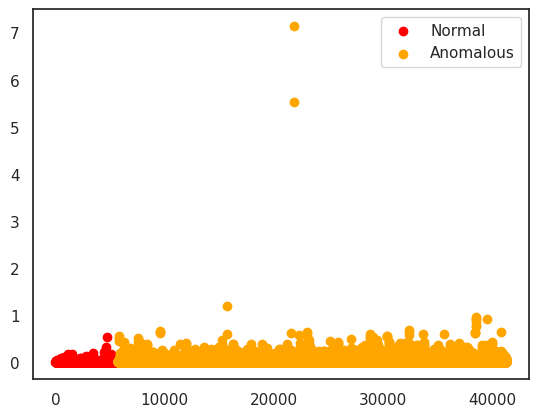

In [59]:
import matplotlib.pyplot as plt 
j = 0
colors = ["red", "orange", "gold", "green", "black"]
for i, (label, errors) in enumerate(rec_error_label.items()):
    n = len(errors)
    plt.scatter(np.arange(j, (j+n), 1), errors, color = colors[i], label = label)
    j = j+n

plt.legend()

In [60]:

len(reconstruction_errors)

41331

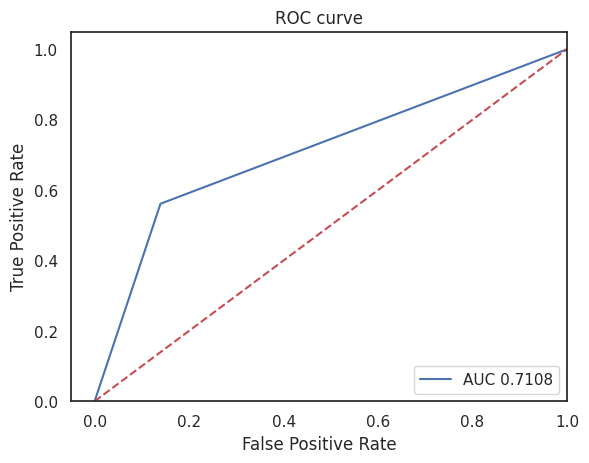

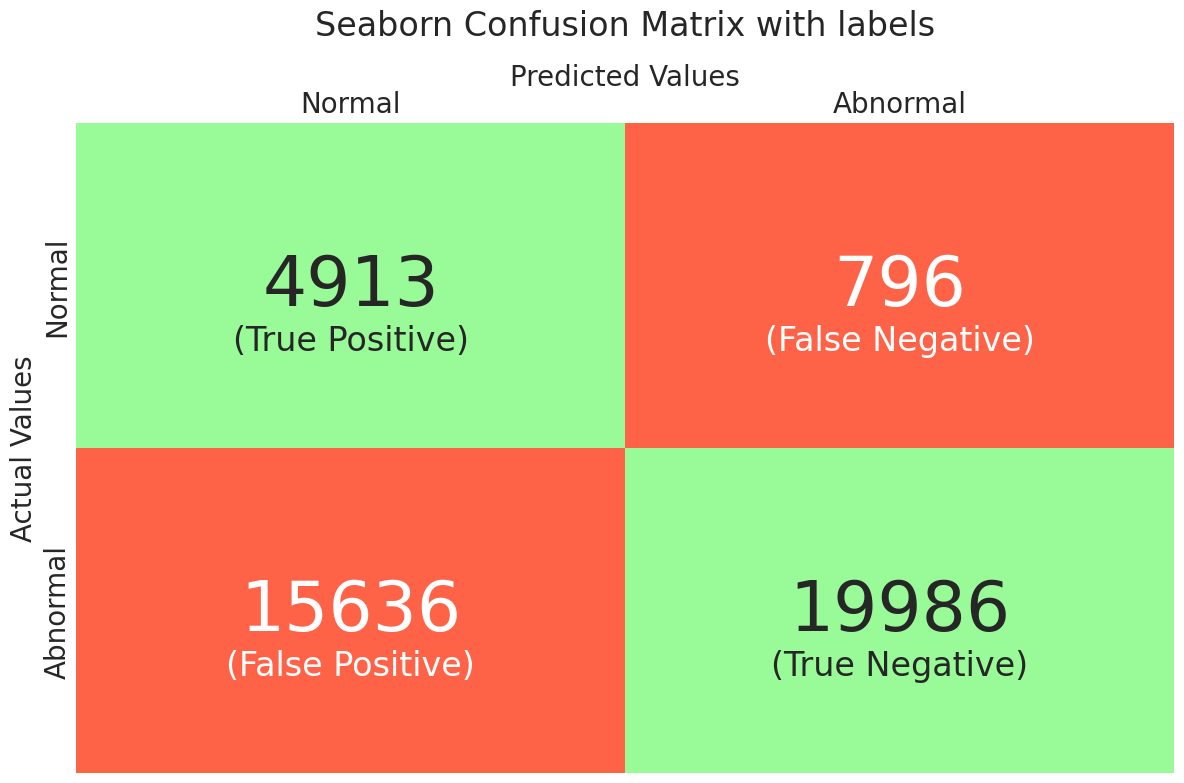

In [61]:
from time import sleep
best_th = 0.0
best_auc = 0.0
normal_mse = []
anomalous_mse = []
count_decr = 0 
fprs = [0]
tprs = [0]
thresholds = np.arange(0.01, 0.1, 0.0002) #np.arange(0.01, 0.5, 0.005)
for j, threshold in enumerate(thresholds):
    print(threshold)
    y_preds = []
    for i, recon_error in enumerate(reconstruction_errors):

        if j == 0:
            if y_test[i] == 0:
                normal_mse.append(recon_error)
            else:
                anomalous_mse.append(recon_error)

        if recon_error > threshold:
            y_preds.append(1)
        else:
            y_preds.append(0)
                
        y = y_test[i]
        
    sleep(0.5)
    clear_output(wait = True)
    metrics, to_print = validate_model(y_test, y_preds)
    auc_score = metrics["auc_score"]
    if auc_score > best_auc:
        best_th = threshold
        best_auc = auc_score
    if auc_score < best_auc:
        count_decr += 1
    if count_decr >= 10: 
        break
    fpr, tpr, _ = roc_curve(y_test, y_preds)
    fprs.append(fpr[1])
    tprs.append(tpr[1])
    print(to_print)
fprs.append(1)
tprs.append(1)

Text(-0.04, 3333, 'TP')

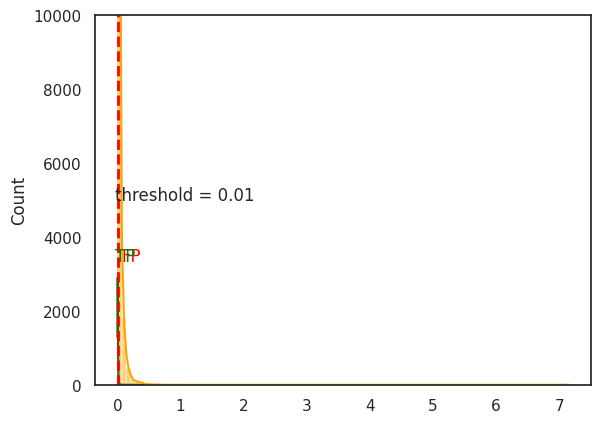

In [62]:
import seaborn as sns 

ymax = 10000
sns.histplot(normal_mse, kde=True, 
             bins=100, color = 'green')
sns.histplot(anomalous_mse, kde=True, 
             bins=100, color = 'orange')
plt.vlines(x = best_th, ymin = 0, ymax = ymax, color = "red", linewidth = 2, linestyles = "dashed")
plt.ylim([0, ymax])
plt.text(x = best_th - 0.05, y = int(ymax/2), s = "threshold = {}".format(round(best_th, 6)))
plt.text(x = best_th + 0.05, y = int(ymax/3), s = "FP", color = "red")
plt.text(x = best_th - 0.05, y =  int(ymax/3), s = "TP", color = "green")

In [63]:
best_th, best_auc

(0.01, 0.7225619692825935)

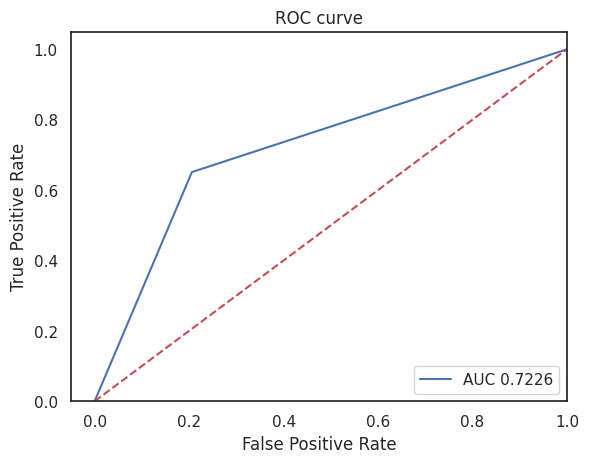

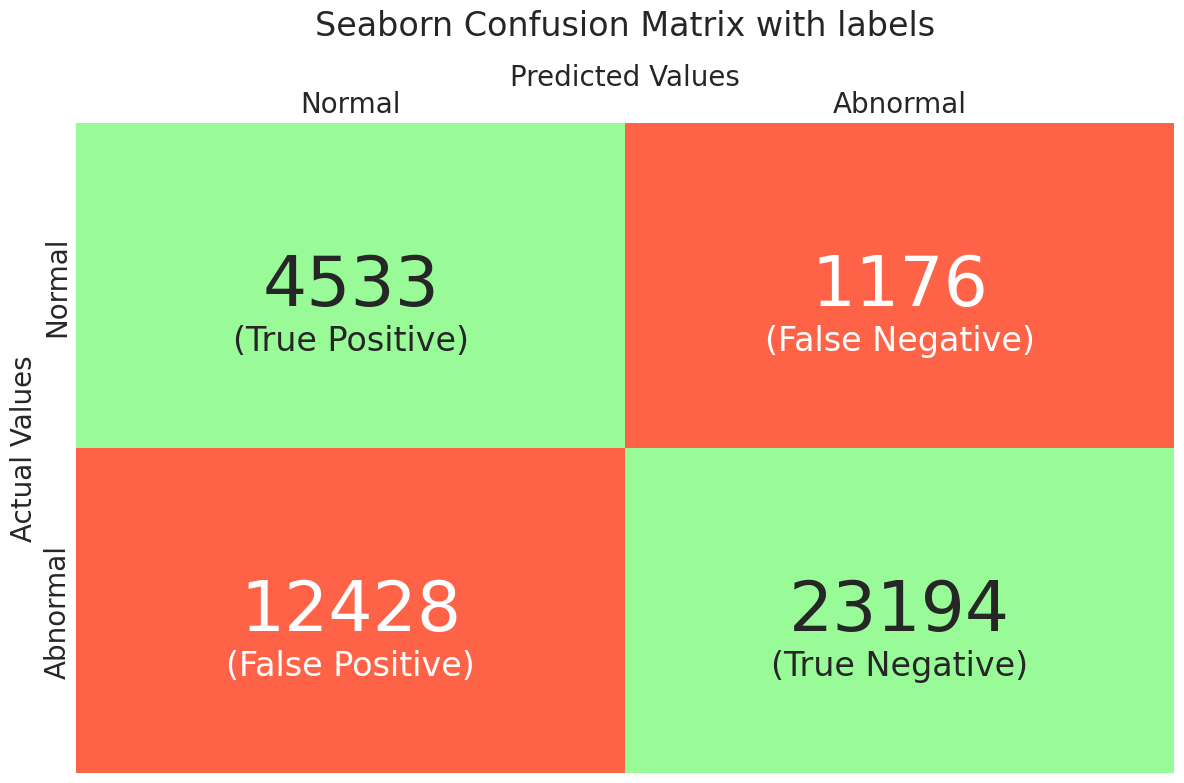

Accuracy: 0.6708523868282887 
 F1 score: 0.39991177767975294 
 Sensitivity: 0.7940094587493431 
 Specificity: 0.6511144798158441 
 ROC AUC score: 0.7225619692825935 
 False Allarm Rate: 0.20599054125065686, Missed Allarm Rate: 0.34888552018415586 
 Confusion Matrix: 
 [[ 4533  1176]
 [12428 23194]] 
 Classification Report: 
               precision    recall  f1-score   support

           0       0.27      0.79      0.40      5709
           1       0.95      0.65      0.77     35622

    accuracy                           0.67     41331
   macro avg       0.61      0.72      0.59     41331
weighted avg       0.86      0.67      0.72     41331
 



In [64]:
#best_th = 0.026

windows_labels_preds = []
for i, recon_error in enumerate(reconstruction_errors):
    
    if recon_error > best_th:
        windows_labels_preds.append(1)
    else:
        windows_labels_preds.append(0)
                
    y = y_test[i]
        
metrics, to_print = validate_model(y_test, windows_labels_preds)
auc_score = metrics["auc_score"]
print(to_print)

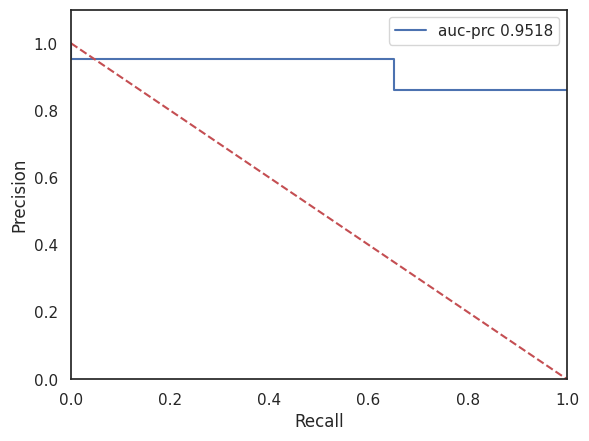

In [65]:
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve

prec, recall, _ = precision_recall_curve(y_test,  windows_labels_preds)
auc_pr = auc(recall, prec)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot(label="auc-prc {}".format(round(auc_pr, 4)))
plt.plot([0, 1], [1, 0], "--r")
plt.xlim([0, 1])
plt.ylim([0, 1.1])
plt.legend()

In [66]:
idxs_normal = torch.argwhere(y_test == 0)
idxs_normal

tensor([[   0],
        [   1],
        [   2],
        ...,
        [5706],
        [5707],
        [5708]])

In [67]:
X_test_norm = X_test[idxs_normal]
X_test_norm = torch.squeeze(X_test_norm, dim = 1)
X_test_norm.shape

torch.Size([5709, 1, 15, 2000])

In [68]:
X_test_afib = torch.load("xtest_afib_xl.pt")
X_test_afib = torch.stack(X_test_afib, dim = 0)
X_test_afib.shape

torch.Size([2130, 1, 15, 2000])

In [69]:
X_test_2 = torch.cat([X_test_norm, X_test_afib], dim = 0)
X_test_2.shape

torch.Size([7839, 1, 15, 2000])

In [70]:
y_test_2 = [0 for idx in idxs_normal]
[y_test_2.append(1) for elem in X_test_afib]
y_test_2 = torch.tensor(y_test_2)
y_test_2

tensor([0, 0, 0,  ..., 1, 1, 1])

In [71]:
y_test_2.shape

torch.Size([7839])

In [72]:
map_y_final_2 = {0: "Normal", 1: "AFIB"}
labels = list(map_y_final_2.values())
labels

['Normal', 'AFIB']

In [73]:
from torch.functional import F 
import numpy as np 

fs = 500 
nchs = 15 
interval2 = fs*3
interval = fs*4
reconstruction_errors = []
n = X_test_2.shape[0]
rec_error_label = {label: [] for label in labels}
                   
for i, batch_data in enumerate(X_test_2): 
    
    batch_data = batch_data.to(device)
    #print(batch_data.shape)
    batch_data = torch.unsqueeze(batch_data, dim = 0).to(device)

    #print(batch_data.shape)
    reconstruction_all = np.zeros((nchs, interval2))        

    with torch.no_grad():

        reconstruction = model(batch_data)
        reconstruction_error = F.mse_loss(reconstruction[0, 0, :, :interval2], batch_data[0, 0, :, :interval2]).item()
        if i+1 in np.arange(1, n, 1000):
            label = map_y_final_2[y_test_2[i].item()]
            print(i+1, "/", n, "Recon error:", round(reconstruction_error, 6), "Label:", label, end = "\r")
            torch.cuda.empty_cache()
            gc.collect()
        reconstruction_errors.append(reconstruction_error)

        rec_error_label[label].append(reconstruction_error)
        recon_np = (reconstruction[0, 0, :, :interval2].cpu().detach().numpy()).reshape(1, nchs, interval2)
        reconstruction_all[:, :] = recon_np[0, :, :interval2]


    del batch_data
    del reconstruction 
    del reconstruction_error
    del recon_np
    

In [74]:
y_test_2

tensor([0, 0, 0,  ..., 1, 1, 1])

In [75]:
import pandas as pd 
df = pd.DataFrame([], columns = ["Label", "Min MSE", "Max MSE", "Mean MSE (+/- STD"])
for i, (label, errors) in enumerate(rec_error_label.items()):
    min_ = min(errors)
    max_ = max(errors)
    mean = round(np.mean(errors), 4)
    std = round(np.std(errors), 4)
    df.loc[i] = [label, min_, max_, f"{mean}+-{std}"]
df.set_index("Label")

,Min MSE,Max MSE,Mean MSE (+/- STD
Label,,,
Normal,0.001497,0.529494,0.01+-0.0175
AFIB,0.002038,0.530984,0.0416+-0.063


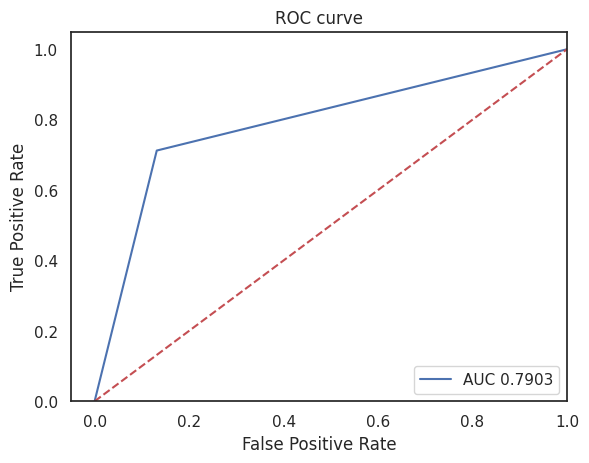

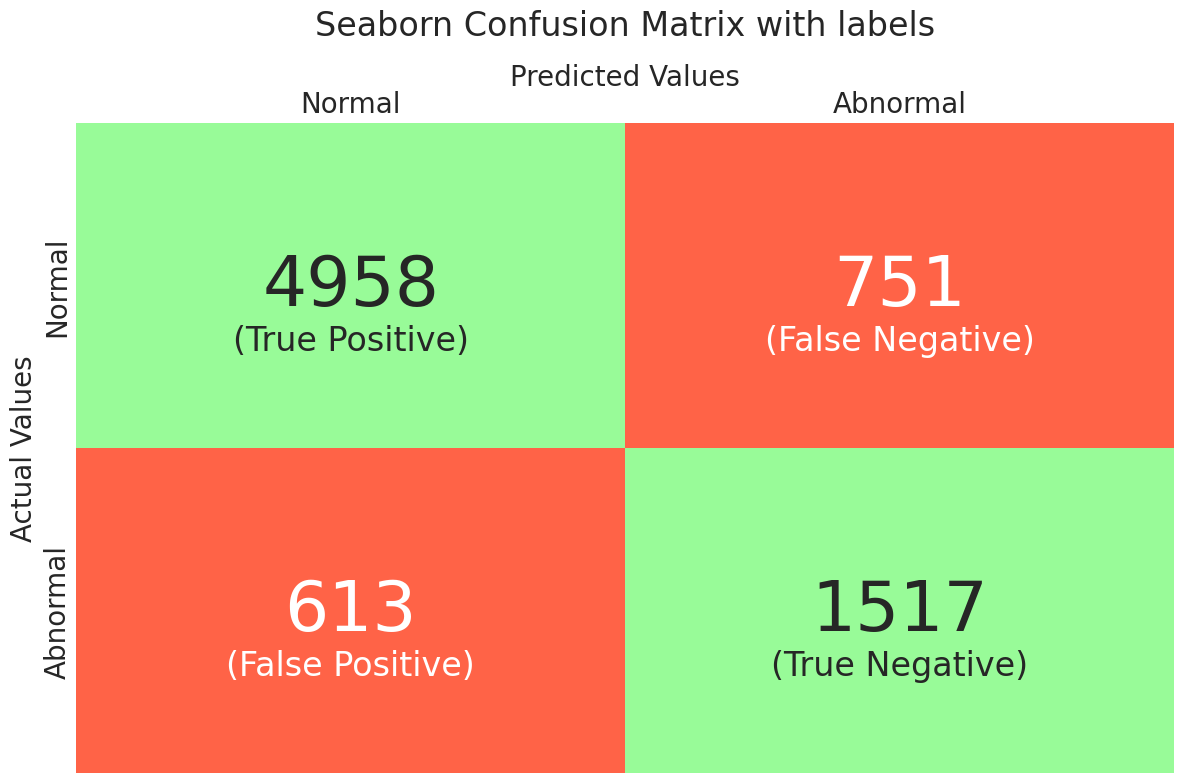

In [76]:
from time import sleep
import matplotlib.pyplot as plt 

best_th = 0.0
best_auc = 0.0
normal_mse = []
anomalous_mse = []
count_decr = 0 
fprs = [0]
tprs = [0]
thresholds = np.arange(0.008, 0.1, 0.0002) #np.arange(0.01, 0.5, 0.005)
for j, threshold in enumerate(thresholds):
    print(threshold)
    y_preds = []
    for i, recon_error in enumerate(reconstruction_errors):

        if j == 0:
            if y_test_2[i] == 0:
                normal_mse.append(recon_error)
            else:
                anomalous_mse.append(recon_error)

        if recon_error > threshold:
            y_preds.append(1)
        else:
            y_preds.append(0)
                
        y = y_test_2[i]
        
    sleep(0.5)
    clear_output(wait = True)
    metrics, to_print = validate_model(y_test_2, y_preds)
    auc_score = metrics["auc_score"]
    if auc_score > best_auc:
        best_th = threshold
        best_auc = auc_score
    if auc_score < best_auc:
        count_decr += 1
    if count_decr >= 10: 
        break
    fpr, tpr, _ = roc_curve(y_test_2, y_preds)
    fprs.append(fpr[1])
    tprs.append(tpr[1])
    print(to_print)
fprs.append(1)
tprs.append(1)

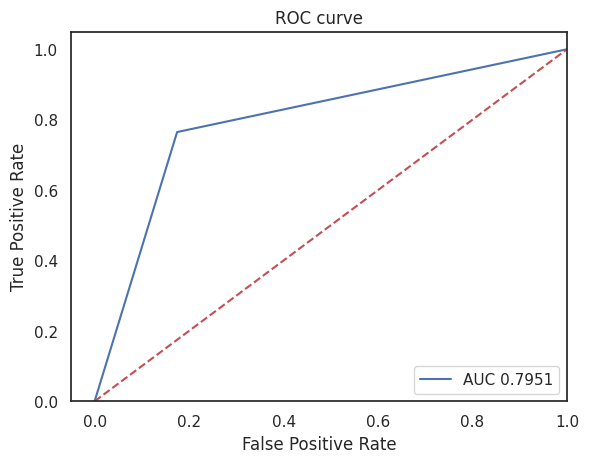

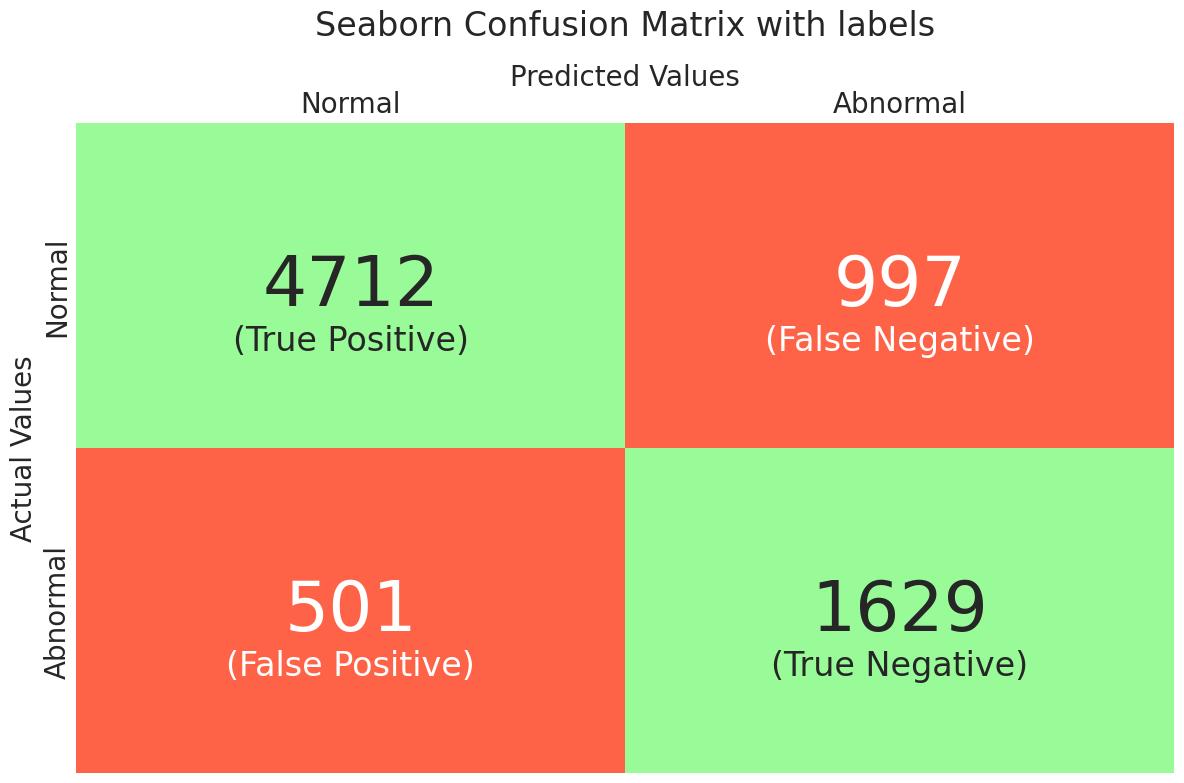

Accuracy: 0.8089041969638985 
 F1 score: 0.8628456326680094 
 Sensitivity: 0.8253634612016115 
 Specificity: 0.7647887323943662 
 ROC AUC score: 0.7950760967979889 
 False Allarm Rate: 0.1746365387983885, Missed Allarm Rate: 0.2352112676056338 
 Confusion Matrix: 
 [[4712  997]
 [ 501 1629]] 
 Classification Report: 
               precision    recall  f1-score   support

           0       0.90      0.83      0.86      5709
           1       0.62      0.76      0.69      2130

    accuracy                           0.81      7839
   macro avg       0.76      0.80      0.77      7839
weighted avg       0.83      0.81      0.81      7839
 



In [77]:
windows_labels_preds = []
for i, recon_error in enumerate(reconstruction_errors):
    
    if recon_error > best_th:
        windows_labels_preds.append(1)
    else:
        windows_labels_preds.append(0)
                
    y = y_test_2[i]
        
metrics, to_print = validate_model(y_test_2, windows_labels_preds)
auc_score = metrics["auc_score"]
print(to_print)

In [78]:
best_th

0.010800000000000008

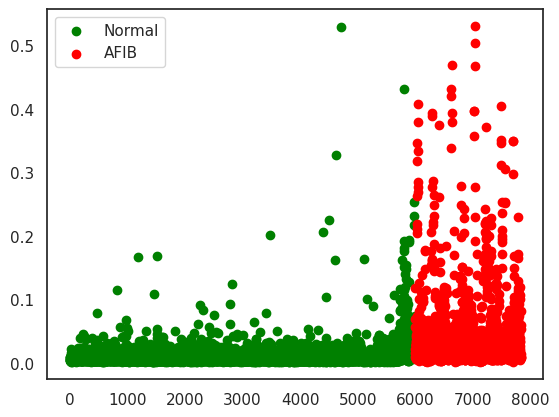

In [79]:
import matplotlib.pyplot as plt 
j = 0
colors = ["green", "red"] #["red", "orange", "gold", "green", "black"]
for i, (label, errors) in enumerate(rec_error_label.items()):
    n = len(errors)
    plt.scatter(np.arange(j, (j+n), 1), errors, color = colors[i], label = label)
    j = j+n
    #plt.ylim([0, 0.1])
plt.legend()